In [18]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

INPUT_FOLDER = 'input/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

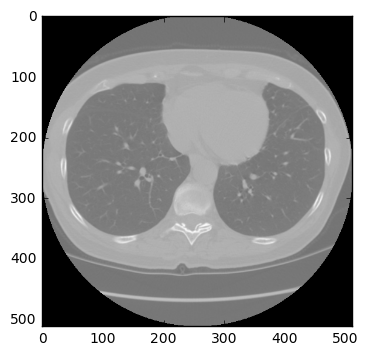

In [19]:
slics = [dicom.read_file(INPUT_FOLDER + patients[1] + '/' + s) for s in os.listdir(INPUT_FOLDER + patients[1])]
plt.imshow(slics[80].pixel_array, cmap=plt.cm.gray)

In [21]:
def load_slices(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[10].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])/10
#         slice_thickness = np.abs(slices[1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])    
    except:
        slice_thickness = np.abs(slices[10].SliceLocation - slices[0].SliceLocation)/10
#         slice_thickness = np.abs(slices[1].SliceLocation - slices[0].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [22]:
def convert_to_HU(slices):
    #images is 3d array, it stores 2d pixel_arrays from each slice belonging to a patient
    images = np.stack([s.pixel_array for s in slices])
    images = images.astype(np.int16)

    # Set outside-of-scan pixels to 0
    images[images == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):      
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            images[slice_number] = slope * images[slice_number].astype(np.float64)
            images[slice_number] = images[slice_number].astype(np.int16)
            
        images[slice_number] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

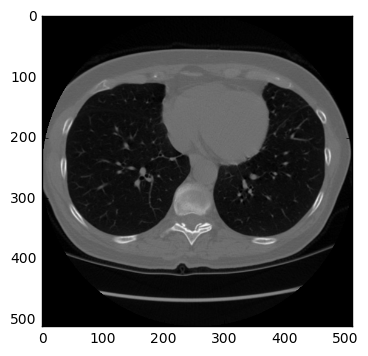

In [23]:
slics_HU = convert_to_HU(slics)
plt.imshow(slics_HU[80], cmap=plt.cm.gray)

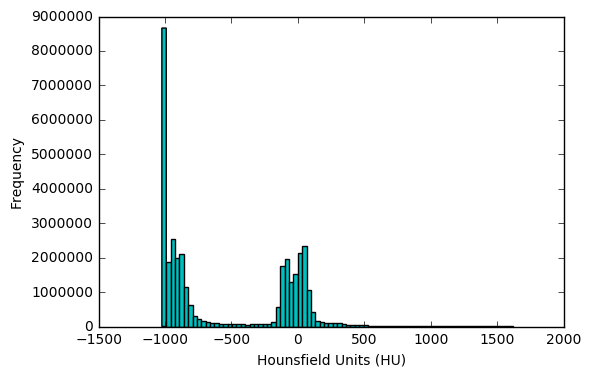

In [24]:
first_patient_slices = load_slices(INPUT_FOLDER + patients[1]) #load slices for each patient and add missing metadata, thickness
first_patient_HUpixels = convert_to_HU(first_patient_slices)
plt.hist(first_patient_HUpixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [27]:
def resample(images, slices, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = images.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / images.shape
    new_spacing = spacing / real_resize_factor
    
    images = scipy.ndimage.interpolation.zoom(images, real_resize_factor, mode='nearest')
    
    return images, new_spacing

In [28]:
pix_resampled, spacing = resample(first_patient_HUpixels, first_patient_slices, [1,1,1])
print("Shape before resampling\t", first_patient_HUpixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


In [29]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    face_color = [0.45, 0.45, 0.75]
    mesh = Poly3DCollection(verts[faces], alpha=0.05)    
    mesh.set_facecolor(face_color)  
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

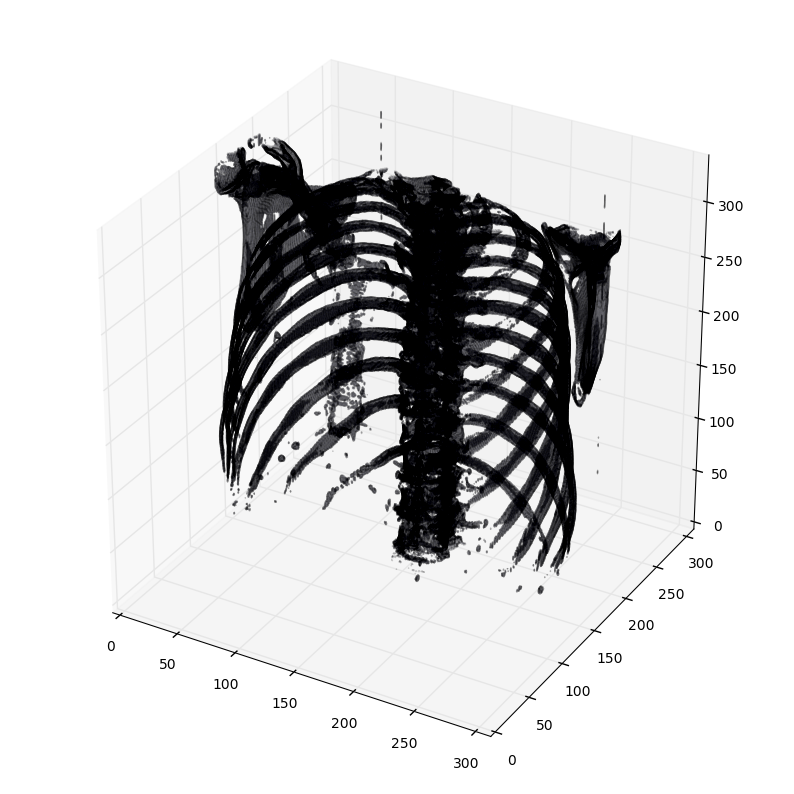

In [107]:
plot_3d(pix_resampled, 400)

In [30]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(pixels, fill_lung_structures=True):
    # 0 is treated as background, which is non-ROI
    # Use -320 as a threshold based on wikipedia and the histogram we generated above
    binary_image = np.array(pixels > -320, dtype=np.int8)+1
    
    #label connnected regions with an integer
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
     
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: 
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: 
        binary_image[labels != l_max] = 0
 
    return binary_image

In [31]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

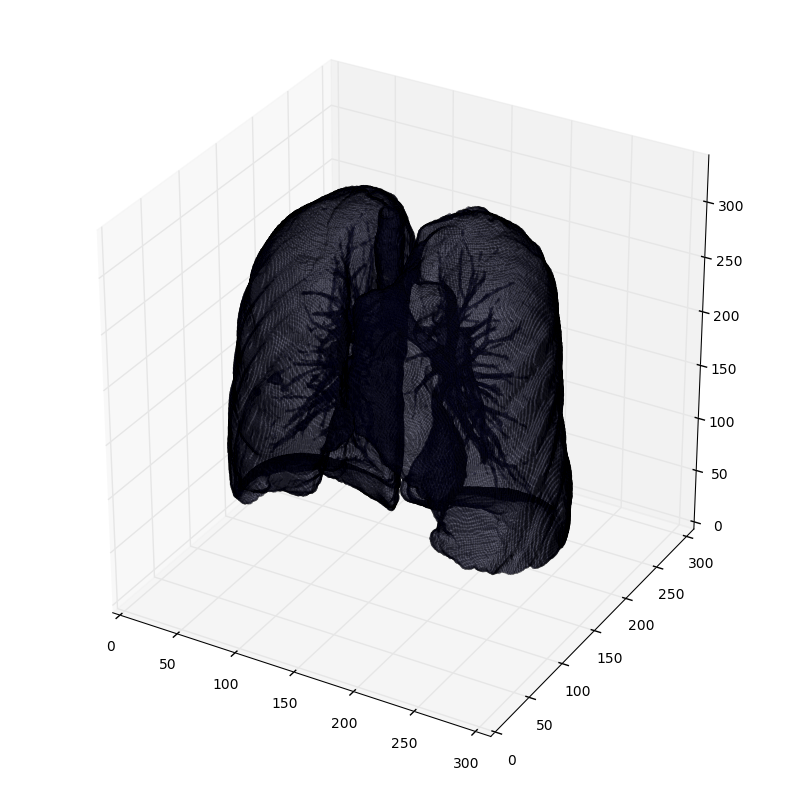

In [32]:
plot_3d(segmented_lungs, 0)

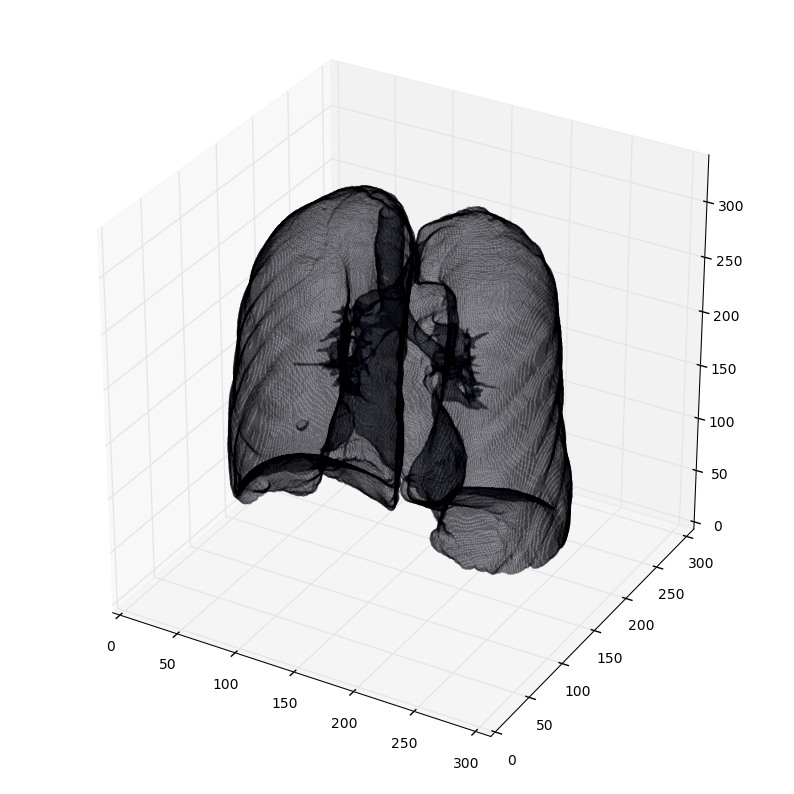

In [46]:
plot_3d(segmented_lungs_fill, 0)

In [36]:
from skimage.morphology import disk,ball
from skimage import morphology

array([[[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]]], dtype=uint8)

In [44]:
eroded = morphology.erosion(segmented_lungs_fill,ball(1))
dilation = morphology.dilation(eroded,ball(3))

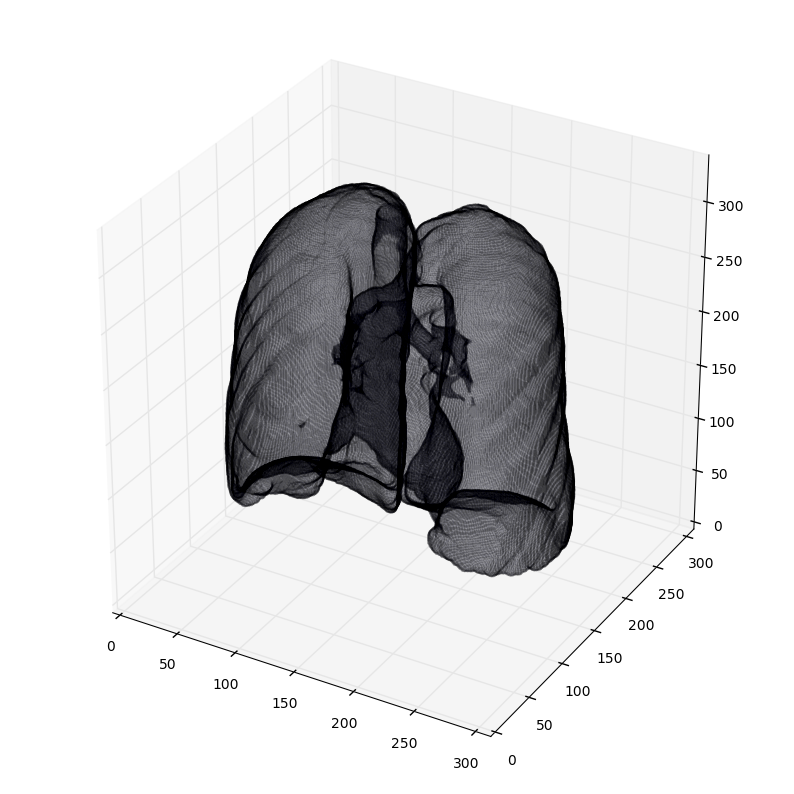

In [51]:
plot_3d(dilation, 0)

In [78]:
image = np.multiply(dilation, pix_resampled)

In [79]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [81]:
image[150][150]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,   -69,  -111,  -531,  -857,  -847,  -863,
        -836,  -846,  -841,  -845,  -843,  -813,  -810,  -849,  -895,
        -915,  -887,  -865,  -884,  -879,  -899,  -894,  -884,  -871,
        -774,  -800,  -886,  -826,  -744,  -654,  -642,  -637,  -703,
        -843,  -908,  -920,  -911,  -851,  -856,  -929,  -946,  -893,
        -867,  -898,  -883,  -890,  -867,  -889,  -910,  -901,  -909,
        -902,  -885,  -872,  -898,  -898,  -886,  -909,  -864,  -800,
        -863,  -895,  -767,  -834,  -859,  -875,  -912,  -943,  -898,
        -736,  -727,  -861,  -956, -1001,  -894,  -600,  -276,   -79,
          -5,    28,    11,    21,    36,     8,    29,    12,     5,
          19,    -1,   -17,   -35,   -60,   -99,  -139,  -115,   -86,
        -415,  -839,  -878,  -843,  -849,  -827,  -802,  -825,  -812,
        -829,  -801,

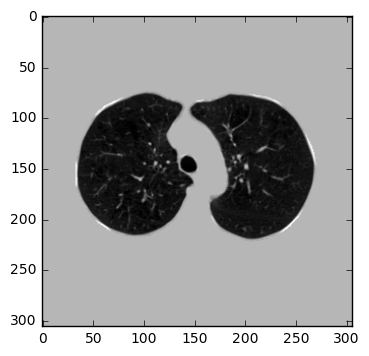

In [90]:
image = normalize(image)
image = zero_center(image)

plt.imshow(image[250], cmap=plt.cm.gray)
# np.save(INPUT_FOLDER+"Images.dcm", image)

In [85]:
first_patient_HUpixels.shape

(134, 512, 512)

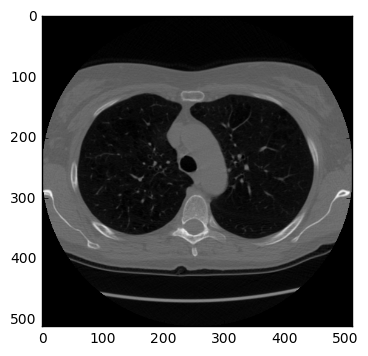

In [100]:
plt.imshow(first_patient_HUpixels[100],cmap=plt.cm.gray)